# Analysis of forest waste wood in British Columbia

## Background

March 22, 2022

This notebook summarizes observations of waste wood rate (WR) in British Columbia (BC). The objectives included an improved understanding of: 

1) Average values of WR stratified by district;

2) Average values of WR stratified by region (coast or interior);

3) Relationship between WR and harvest yield (m3/ha);

4) Relationship between WR and stand age;

5) Average fractions of dispersed, accumulated (piled), and left standing waste wood

## Methods

The analysis is conducted using a compilation of harvest volume information from the Harvest Billing System (HBS), waste from the Wood Residues and Waste System (WRWS). The time span ranges from 2007-2021. Although waste information is available at the level of cutblock, harvest volume is not. The analysis was, therefore, conducted at the level of timber mark (TM). Waste for a TM was calculated from a weighted average of waste vaues from one or more cutblocks with different area.

WR is defined as the total avoidable and unavoidable waste wood divided by felled volume. Felled volume was defined as the delivered volume ("Normal Production" of "Logs" in HBS) plus the area-weighted avoidable and unavoidable waste from WRWS. By adopting this definition of WR, the value 1-WR direclty determines the amount of merchantable biomass that is transferred to mills in carbon models.

Stand age at the time of felling was taken from the RESULTS Opening Layer.

In [2]:
# Import modules and prepare notebook settings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.io
import scipy.io as spio
import statsmodels.api as sm
import statsmodels.formula.api as smf
from scipy.optimize import curve_fit
from scipy import stats, linalg
import warnings
from IPython.display import display,HTML,Image
from fcgadgets.macgyver import util_general as gu
from fcgadgets.cbrunner import cbrun_util as cbu
%matplotlib inline
plt.style.use('ggplot')
warnings.filterwarnings('ignore')
display(HTML("<style>.container { width:80% !important; } .output {align-items: left; }</style>"))

In [3]:
# Graphics parameters
plt.rcParams.update( cbu.Import_GraphicsParameters('FCI_Demo') )
tickl=1.5;

In [3]:
# Import data
dTM=gu.ipickle(r'C:\Data\Harvest\HBS\HavestSummary_ByTM.pkl')

In [4]:
# Derived variables

# Volume felled (Volume delivered + Waste)
#dTM['V Felled m3/ha']=dTM['V Logs Delivered Abs m3/ha']+dTM['V NonLog Delivered Abs m3/ha']+dTM['Waste Total m3/ha']
dTM['V Felled m3/ha']=dTM['V Logs Delivered Abs m3/ha']+dTM['Waste Total m3/ha']

# Waste ratio
dTM['WR']=dTM['Waste Total m3/ha']/dTM['V Felled m3/ha']

# Sawlog recovery ratio
dTM['Sawlog Ratio']=(dTM['V Logs Delivered Grade 1 Abs m3/ha']+dTM['V Logs Delivered Grade 2 Abs m3/ha'])/dTM['V Logs Delivered m3/ha']

# Region
dTM['Reg']=np.array(['Interior' for _ in range(dTM['TM'].size)],dtype=object)
ind=np.where( (dTM['District']=='DCR') | (dTM['District']=='DNI') | (dTM['District']=='DSI') | \
             (dTM['District']=='DSC') | (dTM['District']=='DSQ') | (dTM['District']=='DQC') | \
             (dTM['District']=='DCK') )[0]
dTM['Reg'][ind]='Coast'

# Discrepency in area values between HBS and WS
dTM['Delta A %']=(dTM['DISTURBANCE_GROSS_AREA']-dTM['Waste Net Area Tot'])/dTM['DISTURBANCE_GROSS_AREA']*100

In [5]:
list(dTM.keys())

['TM',
 'N Openings',
 'DISTURBANCE_GROSS_AREA',
 'PLANNED_NET_BLOCK_AREA',
 'Year First',
 'Year Last',
 'District',
 'Tenure Type',
 'V Logs Delivered m3',
 'V Logs Delivered Abs m3',
 'V Logs Delivered m3/ha',
 'V Logs Delivered Abs m3/ha',
 'V Logs Cruise m3/ha',
 'V Logs Waste m3/ha',
 'V Logs Delivered Grade 1 m3/ha',
 'V Logs Delivered Grade 1 Abs m3/ha',
 'V Logs Delivered Grade 1 Abs m3',
 'V Logs Delivered Grade 2 m3/ha',
 'V Logs Delivered Grade 2 Abs m3/ha',
 'V Logs Delivered Grade 2 Abs m3',
 'V Logs Delivered Grade 3 m3/ha',
 'V Logs Delivered Grade 3 Abs m3/ha',
 'V Logs Delivered Grade 3 Abs m3',
 'V Logs Delivered Grade 4 m3/ha',
 'V Logs Delivered Grade 4 Abs m3/ha',
 'V Logs Delivered Grade 4 Abs m3',
 'V Logs Delivered Grade 5 m3/ha',
 'V Logs Delivered Grade 5 Abs m3/ha',
 'V Logs Delivered Grade 5 Abs m3',
 'V Logs Delivered Grade 6 m3/ha',
 'V Logs Delivered Grade 6 Abs m3/ha',
 'V Logs Delivered Grade 6 Abs m3',
 'V Logs Delivered Grade 7 m3/ha',
 'V Logs Deliv

In [6]:
np.unique(dTM['District'])

array(['', 'DCC', 'DCK', 'DCR', 'DCS', 'DFN', 'DKA', 'DKM', 'DMH', 'DMK',
       'DND', 'DNI', 'DOS', 'DPC', 'DPG', 'DQC', 'DQU', 'DRM', 'DSC',
       'DSE', 'DSI', 'DSQ', 'DSS', 'DVA'], dtype=object)

## Summary stats by region

In [7]:
regL=['Coast','Interior']

df=pd.DataFrame( [],
        index=pd.Index(['Volume delivered (m3/ha)',
                        'Volume delivered Grades 1 and 2 (m3/ha)',
                        'Volume delivered Grade 4 (m3/ha)',
                        'Total waste wood (m3/ha)',
                        'Volume felled (m3/ha)', \
                        'WR (%)',
                        'WR excluding left standing (%)',
                        'Dispersed (%)', \
                        'Accumulation (%)',
                        'Left standing (%)'],name='Variables'),
        columns=pd.Index(regL, name='Regions') )

for reg in regL:
    
    ind=np.where( (dTM['Reg']==reg) & \
                 (dTM['Year First']>2006) & \
                 (dTM['V Felled m3/ha']>0) & \
                 (dTM['V Felled m3/ha']<2000) & \
                 (dTM['Waste N Entries']>0) & \
                 (np.abs(dTM['Delta A %'])<5) & \
                 (dTM['Waste Net Area Tot']>0) & \
                 (dTM['WR']>=0) & (dTM['WR']<1) )[0]
    # & (dTM['Tenure Type']=='Forest Licence')
    
    df.loc['Volume delivered (m3/ha)',reg]=np.round(np.mean(dTM['V Logs Delivered Abs m3/ha'][ind]))
    df.loc['Volume delivered Grades 1 and 2 (m3/ha)',reg]=np.round(np.mean(dTM['V Logs Delivered Grade 1 Abs m3/ha'][ind]+dTM['V Logs Delivered Grade 2 Abs m3/ha'][ind]))
    df.loc['Volume delivered Grade 4 (m3/ha)',reg]=np.round(np.mean(dTM['V Logs Delivered Grade 4 Abs m3/ha'][ind]))
    df.loc['Total waste wood (m3/ha)',reg]=np.round(np.mean(dTM['Waste Total m3/ha'][ind]))
    df.loc['Volume felled (m3/ha)',reg]=np.round(np.mean(dTM['V Felled m3/ha'][ind]))
    
    w=dTM['Waste Total m3/ha'][ind]*dTM['DISTURBANCE_GROSS_AREA'][ind]
    vf=dTM['V Felled m3/ha'][ind]*dTM['DISTURBANCE_GROSS_AREA'][ind]
    ind2=np.where(np.isnan(w+vf)==False)[0]
    df.loc['WR (%)',reg]=np.round((np.nansum(w[ind2])/np.nansum(vf[ind2]))*100)
    
    #df.loc['WR (%)',reg]=np.round(np.mean(dTM['WR'][ind])*100)
    #df.loc['WR (%)',reg]=np.round(np.median(dTM['WR'][ind])*100)
    w2=w*(1-dTM['Waste Standing %'][ind]/100)
    df.loc['WR excluding left standing (%)',reg]=np.round((np.nansum(w2[ind2])/np.nansum(vf[ind2]))*100)
    
    df.loc['Dispersed (%)',reg]=np.round(np.nanmean(dTM['Waste Dispersed %'][ind]))
    df.loc['Accumulation (%)',reg]=np.round(np.nanmean(dTM['Waste Accumulation %'][ind]))
    df.loc['Left standing (%)',reg]=np.round(np.nanmean(dTM['Waste Standing %'][ind]))
df

Regions,Coast,Interior
Variables,,
Volume delivered (m3/ha),699.0,299.0
Volume delivered Grades 1 and 2 (m3/ha),0.0,209.0
Volume delivered Grade 4 (m3/ha),0.0,84.0
Total waste wood (m3/ha),118.0,12.0
Volume felled (m3/ha),817.0,312.0
WR (%),15.0,4.0
WR excluding left standing (%),14.0,4.0
Dispersed (%),69.0,34.0
Accumulation (%),28.0,65.0


## Summary by district

In [8]:
regL=list(np.unique(dTM['District']))

df=pd.DataFrame([],
        index=pd.Index(['Total (m3/ha)','Grade 4 (m3/ha)','WR (%)','Dispersed (%)','Accumulation (%)','Left standing (%)'],name='Variables'),
        columns=pd.Index(regL, name='Regions'))
for reg in regL:
    ind=np.where( (dTM['District']==reg) & \
                 (dTM['Year First']>2006) & \
                 (dTM['V Logs Delivered Abs m3/ha']>0) & \
                 (dTM['V Felled m3/ha']>0) & \
                 (dTM['V Felled m3/ha']<2000) & \
                 (dTM['Waste N Entries']>0) & \
                 (np.abs(dTM['Delta A %'])<100) & \
                 (dTM['Waste Standing %']>=0) & \
                 (dTM['Waste Net Area Tot']>0) & \
                 (dTM['WR']>=0) & (dTM['WR']<1) )[0]
    
    df.loc['Total (m3/ha)',reg]=np.round(np.mean(dTM['V Logs Delivered Abs m3/ha'][ind]))    
    df.loc['Grade 4 (m3/ha)',reg]=np.round(np.mean(dTM['V Logs Delivered Grade 4 Abs m3/ha'][ind]))    
    w=dTM['Waste Total m3/ha'][ind]*dTM['PLANNED_NET_BLOCK_AREA'][ind]
    vf=dTM['V Felled m3/ha'][ind]*dTM['PLANNED_NET_BLOCK_AREA'][ind]
    df.loc['WR (%)',reg]=np.round((np.nansum(w)/np.nansum(vf))*100)
    
    df.loc['Dispersed (%)',reg]=np.round(np.nanmean(dTM['Waste Dispersed %'][ind]))
    df.loc['Accumulation (%)',reg]=np.round(np.nanmean(dTM['Waste Accumulation %'][ind]))
    df.loc['Left standing (%)',reg]=np.round(np.nanmean(dTM['Waste Standing %'][ind]))
df.T

Variables,Total (m3/ha),Grade 4 (m3/ha),WR (%),Dispersed (%),Accumulation (%),Left standing (%)
Regions,,,,,,
,247.0,41.0,23.0,37.0,58.0,5.0
DCC,211.0,57.0,4.0,8.0,91.0,0.0
DCK,542.0,0.0,11.0,57.0,41.0,3.0
DCR,684.0,0.0,12.0,71.0,26.0,3.0
DCS,295.0,74.0,3.0,4.0,96.0,0.0
DFN,354.0,105.0,20.0,36.0,60.0,4.0
DKA,289.0,65.0,4.0,18.0,80.0,2.0
DKM,504.0,130.0,21.0,57.0,23.0,19.0
DMH,210.0,69.0,4.0,19.0,79.0,1.0


## By Tenure Type

In [9]:
vf_th=0

regL=list(np.unique(dTM['Tenure Type']))[1:]

df=pd.DataFrame([],
        index=pd.Index(['Volume felled (m3/ha)','WR (%)','Dispersed (%)','Accumulation (%)','Left standing (%)'],name='Variables'),
        columns=pd.Index(regL, name='Regions'))
for reg in regL:
    ind=np.where( (dTM['Tenure Type']==reg) & \
                 (dTM['V Felled m3/ha']>=vf_th) & \
                 (dTM['V Felled m3/ha']<1000) & \
                 (dTM['WR']>=0) & (dTM['WR']<=1) )[0]
    df.loc['Volume felled (m3/ha)',reg]=np.round(np.mean(dTM['V Felled m3/ha'][ind]))
    w=dTM['Waste Total m3/ha'][ind]*dTM['PLANNED_NET_BLOCK_AREA'][ind]
    vf=dTM['V Felled m3/ha'][ind]*dTM['PLANNED_NET_BLOCK_AREA'][ind]
    df.loc['WR (%)',reg]=np.round((np.nansum(w)/np.nansum(vf))*100)
    df.loc['Dispersed (%)',reg]=np.round(np.nanmean(dTM['Waste Dispersed %'][ind]))
    df.loc['Accumulation (%)',reg]=np.round(np.nanmean(dTM['Waste Accumulation %'][ind]))
    df.loc['Left standing (%)',reg]=np.round(np.nanmean(dTM['Waste Standing %'][ind]))
df.T

Variables,Volume felled (m3/ha),WR (%),Dispersed (%),Accumulation (%),Left standing (%)
Regions,,,,,
Community Forest Agreement,273.0,4.0,52.0,47.0,0.0
Community Forest AgreementCommunity Forest Agreement,360.0,3.0,41.0,59.0,1.0
Community Forest AgreementCommunity Forest AgreementCommunity Forest Agreement,355.0,2.0,38.0,62.0,0.0
Community Forest AgreementCommunity Forest AgreementCommunity Forest AgreementCommunity Forest Agreement,342.0,4.0,35.0,65.0,0.0
Community Forest AgreementCommunity Forest AgreementCommunity Forest AgreementCommunity Forest AgreementCommunity Forest Agreement,371.0,3.0,37.0,63.0,0.0
...,...,...,...,...,...
Woodlot LicenceWoodlot LicenceWoodlot LicenceWoodlot LicenceWoodlot LicenceWoodlot LicenceWoodlot Licence,311.0,2.0,32.0,68.0,0.0
Woodlot LicenceWoodlot LicenceWoodlot LicenceWoodlot LicenceWoodlot LicenceWoodlot LicenceWoodlot LicenceWoodlot Licence,355.0,4.0,38.0,62.0,0.0
Woodlot LicenceWoodlot LicenceWoodlot LicenceWoodlot LicenceWoodlot LicenceWoodlot LicenceWoodlot LicenceWoodlot LicenceWoodlot Licence,37.0,0.0,NaN,NaN,NaN


## Relationship between waste rate and felled volume

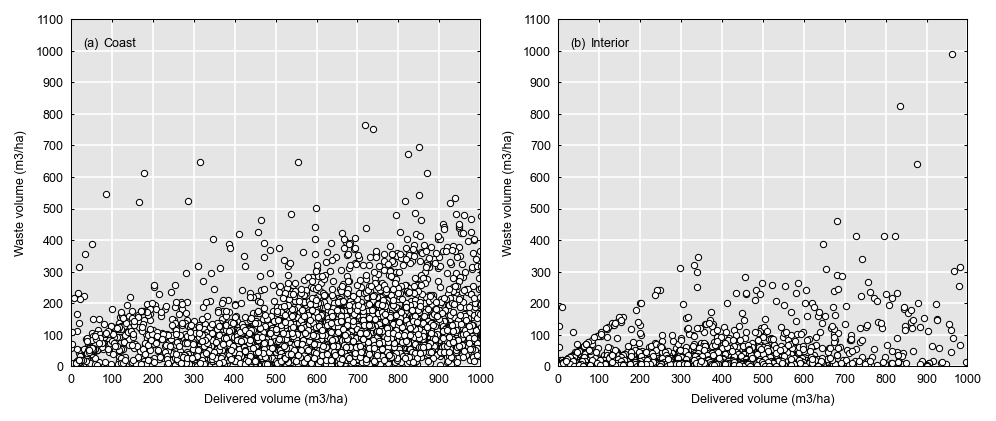

In [10]:
plt.close('all'); fig,ax=plt.subplots(1,2,figsize=gu.cm2inch(16.5,7)); ms=3; lw=0.5

x=dTM['V Logs Delivered Abs m3/ha']
y=dTM['Waste Total m3/ha']
xhat=np.arange(1,1001,1)

ikp=np.where( (dTM['Reg']=='Coast') & \
             (np.abs(dTM['Delta A %'])<100) & \
             (dTM['Waste N Entries']>0) & \
             (x>0) & (x<=1200) & \
             (y>0) & (y<1200) )[0]
# & (dTM['Tenure Type']=='Forest Licence')
x0=x[ikp]
y0=y[ikp]
ax[0].plot(x0,y0,'ko',mfc='w',mec='k',ms=ms,lw=lw,mew=lw)

ax[0].set(position=[0.07,0.1,0.42,0.84],ylim=[0,1000],yticks=np.arange(0,1200,100),ylabel='Waste volume (m3/ha)', \
          xlim=[0,1000],xticks=np.arange(0,1100,100),xlabel='Delivered volume (m3/ha)')
ax[0].yaxis.set_ticks_position('both'); ax[0].xaxis.set_ticks_position('both'); ax[0].tick_params(length=tickl)

ikp=np.where( (dTM['Reg']=='Interior') & \
             (np.abs(dTM['Delta A %'])<5) & \
             (dTM['Waste N Entries']>0) & \
             (x>0) & (x<=1200) & \
             (y>0) & (y<1200) )[0]
# & (dTM['Tenure Type']=='Forest Licence')
x0=x[ikp]
y0=y[ikp]
ax[1].plot(x0,y0,'ko',mfc='w',mec='k',ms=ms,lw=lw,mew=lw)

ax[1].set(position=[0.57,0.1,0.42,0.84],ylim=[0,1000],yticks=np.arange(0,1200,100),ylabel='Waste volume (m3/ha)', \
          xlim=[0,1000],xticks=np.arange(0,1100,100),xlabel='Delivered volume (m3/ha)')
ax[1].yaxis.set_ticks_position('both'); ax[1].xaxis.set_ticks_position('both'); ax[1].tick_params(length=tickl)
gu.axletters(ax,plt,0.03,0.92,Labels=['Coast','Interior'],LabelSpacer=0.05)

In [11]:
def funV(x,a,b,c,d,e):
    y=a+(b-a)*np.exp(-c*x)+d*x+e*x**2
    return y

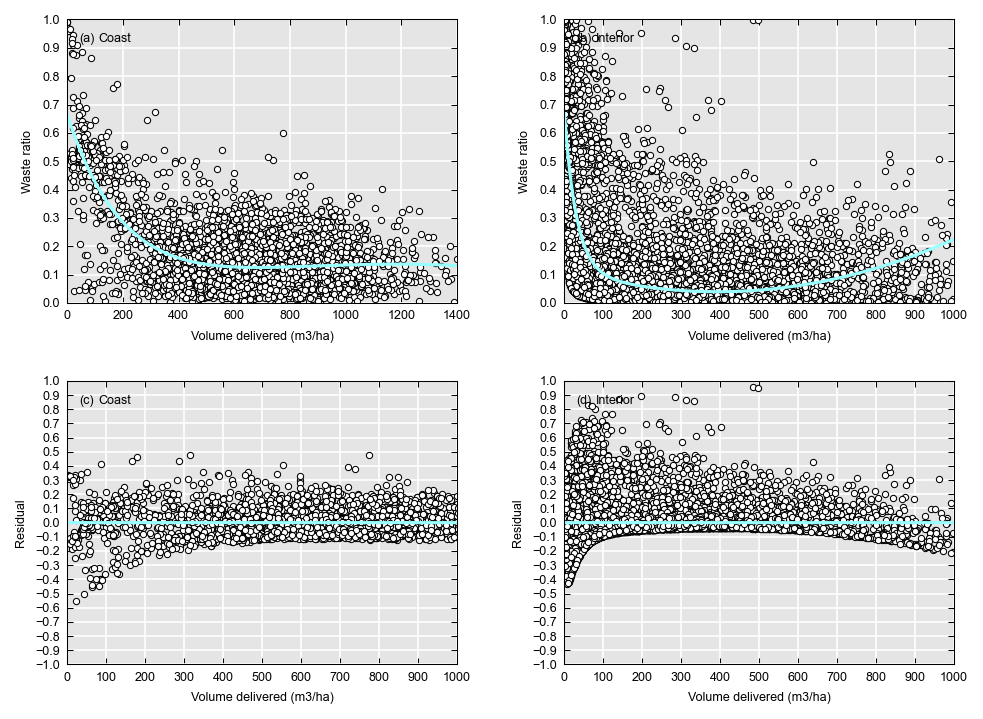

In [12]:
plt.close('all'); fig,ax=plt.subplots(2,2,figsize=gu.cm2inch(16.5,12)); ms=3; lw=0.5

x=dTM['V Logs Delivered Abs m3/ha']#+dTM['V NonLog Delivered m3/ha']
y=dTM['WR']

xhat=np.arange(1,2001,1)

ikp=np.where( (dTM['Reg']=='Coast') & \
             (np.abs(dTM['Delta A %'])<100) & \
             (dTM['Waste N Entries']>0) & \
             (x>0) & (x<=2000) & \
             (y>0) & (y<1) )[0]
# & (dTM['Tenure Type']=='Forest Licence')
x0=x[ikp]
y0=y[ikp]
ax[0,0].plot(x0,y0,'ko',mfc='w',mec='k',ms=ms,lw=lw,mew=lw)

popt,pcov=curve_fit(funV,x0,y0,[3.28729092e-01,9.80527370e-01,2.36993865e-02,-6.96503936e-04,4.73314143e-07])
#print(popt)
yhat=funV(xhat,popt[0],popt[1],popt[2],popt[3],popt[4])
ax[0,0].plot(xhat,yhat,'c-',lw=1.5,color=[0.6,1,1])

#txt='y = ' + str(np.round(md.params[1],decimals=2)) + 'x + ' + str(np.round(md.params[0],decimals=2)) + '\nMean = ' + str(np.round(np.mean(y),decimals=1))
#ax[0].text(290,0.8,txt,ha='right')
ax[0,0].set(position=[0.07,0.58,0.4,0.4],ylim=[0,1],yticks=np.arange(0,1.1,0.1),ylabel='Waste ratio', \
          xlim=[0,1400],xticks=np.arange(0,1600,200),xlabel='Volume delivered (m3/ha)')
ax[0,0].yaxis.set_ticks_position('both'); ax[0,0].xaxis.set_ticks_position('both')

y1=y0-funV(x0,popt[0],popt[1],popt[2],popt[3],popt[4])
ax[1,0].plot(x0,y1,'ko',mfc='w',mec='k',ms=ms,lw=lw,mew=lw)

x1=sm.tools.tools.add_constant(x0)
md=sm.OLS(y1,x1).fit()
md.summary()
xhat=np.linspace(np.min(x1[:,1]),np.max(x1[:,1]),y.shape[0])
yhat=md.predict(np.c_[np.ones(xhat.size),xhat])
ax[1,0].plot(xhat,yhat,'c-',color=[0.6,1,1],lw=1.5)

ax[1,0].set(position=[0.07,0.07,0.4,0.4],ylim=[-0.6,0.6],yticks=np.arange(-1,1.1,0.1),ylabel='Residual', \
          xlim=[0,1000],xticks=np.arange(0,1100,100),xlabel='Volume delivered (m3/ha)')
ax[1,0].yaxis.set_ticks_position('both'); ax[1,0].xaxis.set_ticks_position('both')
#==============================================================================================================
ikp=np.where( (dTM['Reg']=='Interior') & \
             (np.abs(dTM['Delta A %'])<100) & \
             (dTM['Waste N Entries']>0) & \
             (x>=0) & (x<=1000) & \
             (y>0) & (y<1) )[0]
# & (dTM['Tenure Type']=='Forest Licence')
x0=x[ikp]
y0=y[ikp]
ax[0,1].plot(x0,y0,'ko',mfc='w',mec='k',ms=ms,lw=lw,mew=lw)
popt,pcov=curve_fit(funV,x0,y0,[0.08,1,0.01,-0.001,0.0001])
yhat=funV(xhat,popt[0],popt[1],popt[2],popt[3],popt[4])
ax[0,1].plot(xhat,np.maximum(0.01,yhat),'c-',lw=1.5,color=[0.6,1,1])
#txt='y = ' + str(np.round(md.params[1],decimals=2)) + 'x + ' + str(np.round(md.params[0],decimals=2)) + '\nMean = ' + str(np.round(np.mean(y),decimals=1))
#ax[1].text(290,0.8,txt,ha='right')
ax[0,1].set(position=[0.58,0.58,0.4,0.4],ylim=[0,1],yticks=np.arange(0,1.1,0.1),ylabel='Waste ratio', \
          xlim=[0,700],xticks=np.arange(0,1100,100),xlabel='Volume delivered (m3/ha)')
ax[0,1].yaxis.set_ticks_position('both'); ax[0,1].xaxis.set_ticks_position('both')

y1=y0-funV(x0,popt[0],popt[1],popt[2],popt[3],popt[4])
ax[1,1].plot(x0,y1,'ko',mfc='w',mec='k',ms=ms,lw=lw,mew=lw)

x1=sm.tools.tools.add_constant(x0)
md=sm.OLS(y1,x1).fit()
md.summary()
xhat=np.linspace(np.min(x1[:,1]),np.max(x1[:,1]),y.shape[0])
yhat=md.predict(np.c_[np.ones(xhat.size),xhat])
ax[1,1].plot(xhat,yhat,'c-',color=[0.6,1,1],lw=1.5)

ax[1,1].set(position=[0.58,0.07,0.4,0.4],ylim=[-0.6,0.6],yticks=np.arange(-1,1.1,0.1),ylabel='Residual', \
          xlim=[0,700],xticks=np.arange(0,1100,100),xlabel='Volume delivered (m3/ha)')
ax[1,1].yaxis.set_ticks_position('both'); ax[1,1].xaxis.set_ticks_position('both')
gu.axletters(ax,plt,0.03,0.92,Labels=['Coast','Interior','Coast','Interior'],LabelSpacer=0.05)
#gu.PrintFig(r'C:\Users\rhember\OneDrive - Government of BC\Figures\Waste\WasteRatio_vs_Volume','png',900)


## Relationship between waste rate and stand age

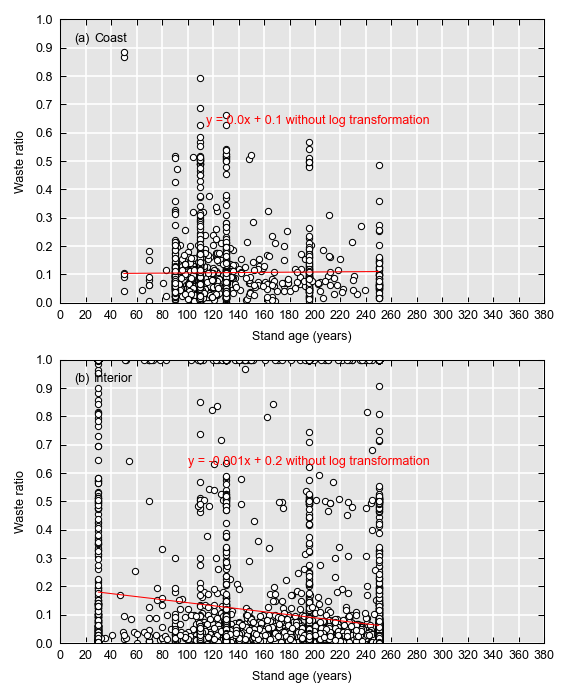

In [13]:
plt.close('all'); fig,ax=plt.subplots(2,1,figsize=gu.cm2inch(10,12)); ms=3; lw=0.5

x=dTM['Age RSLTS WA']
y=dTM['WR']
Ly=np.log(dTM['WR'])

ikp=np.where( (dTM['Reg']=='Coast') & \
              (dTM['Waste N Entries']>0) & \
              (x>0) & (x<1000) & \
              (y>0) & (y<1) & \
              (Ly>-20) & (Ly<=20) )[0]
# & (dTM['Tenure Type']=='Forest Licence')
x0=x[ikp]
y0=y[ikp]
ax[0].plot(x0,y0,'ko',mfc='w',mec='k',ms=ms,lw=lw,mew=lw)

x1=sm.tools.tools.add_constant(x0)
md=sm.OLS(y0,x1).fit()
md.summary()
xhat=np.linspace(np.min(x1[:,1]),np.max(x1[:,1]),y.shape[0])
yhat=md.predict(np.c_[np.ones(xhat.size),xhat])
ax[0].plot(xhat,yhat,'r-',lw=lw)
txt='y = ' + str(np.round(md.params[1],decimals=3)) + 'x + ' + str(np.round(md.params[0],decimals=2)) + ' without log transformation'
ax[0].text(290,0.63,txt,ha='right',color='r')

#x0=x[ikp]
#y0=Ly[ikp]
#x1=sm.tools.tools.add_constant(x0)
#md=sm.OLS(y0,x1).fit()
#md.summary()
#xhat=np.linspace(np.min(x1[:,1]),np.max(x1[:,1]),y.shape[0])
#yhat=np.exp(md.predict(np.c_[np.ones(xhat.size),xhat]))
#ax[0].plot(xhat,yhat,'b-',lw=lw)
#txt='y = ' + str(np.round(md.params[1],decimals=3)) + 'x + ' + str(np.round(md.params[0],decimals=2)) + ' with log transformation'
#ax[0].text(290,0.58,txt,ha='right',color='b')

ax[0].set(position=[0.08,0.58,0.82,0.4],ylim=[0,0.7],yticks=np.arange(0,1.1,0.1),ylabel='Waste ratio',xlim=[0,300],xticks=np.arange(0,400,20),xlabel='Stand age (years)')
ax[0].yaxis.set_ticks_position('both'); ax[0].xaxis.set_ticks_position('both')

ikp=np.where( (dTM['Reg']=='Interior') & \
             (dTM['Waste N Entries']>0) & \
             (x>0) & (x<1000) & \
             (y>=0) & (y<=1) & \
             (Ly>-20) & (Ly<=20) )[0]
# & (dTM['Tenure Type']=='Forest Licence')
x0=x[ikp]
y0=y[ikp]
ax[1].plot(x0,y0,'ko',mfc='w',mec='k',ms=ms,lw=lw,mew=lw)

x1=sm.tools.tools.add_constant(x0)
md=sm.OLS(y0,x1).fit()
md.summary()
xhat=np.linspace(np.min(x1[:,1]),np.max(x1[:,1]),y.shape[0])
yhat=md.predict(np.c_[np.ones(xhat.size),xhat])
ax[1].plot(xhat,yhat,'r-',lw=lw)
txt='y = ' + str(np.round(md.params[1],decimals=3)) + 'x + ' + str(np.round(md.params[0],decimals=2)) + ' without log transformation'
ax[1].text(290,0.63,txt,ha='right',color='r')

#x0=x[ikp]
#y0=Ly[ikp]
#x1=sm.tools.tools.add_constant(x0)
#md=sm.OLS(y0,x1).fit()
#md.summary()
#xhat=np.linspace(np.min(x1[:,1]),np.max(x1[:,1]),y.shape[0])
#yhat=np.exp(md.predict(np.c_[np.ones(xhat.size),xhat]))
#ax[1].plot(xhat,yhat,'b-',lw=lw)
#txt='y = ' + str(np.round(md.params[1],decimals=3)) + 'x + ' + str(np.round(md.params[0],decimals=2)) + ' with log transformation'
#ax[1].text(290,0.58,txt,ha='right',color='b')

ax[1].set(position=[0.08,0.1,0.82,0.4],ylim=[0,0.7],yticks=np.arange(0,1.1,0.1),ylabel='Waste ratio',xlim=[0,300],xticks=np.arange(0,400,20),xlabel='Stand age (years)')
ax[1].yaxis.set_ticks_position('both'); ax[1].xaxis.set_ticks_position('both')
gu.axletters(ax,plt,0.03,0.92,Labels=['Coast','Interior'],LabelSpacer=0.04)
#gu.PrintFig(r'C:\Users\rhember\OneDrive - Government of BC\Figures\Waste\WasteRatio_vs_StandAge','png',900)

## Relationship between utilization measures and beetle-related tree mortality for 12 years leading up to harvest

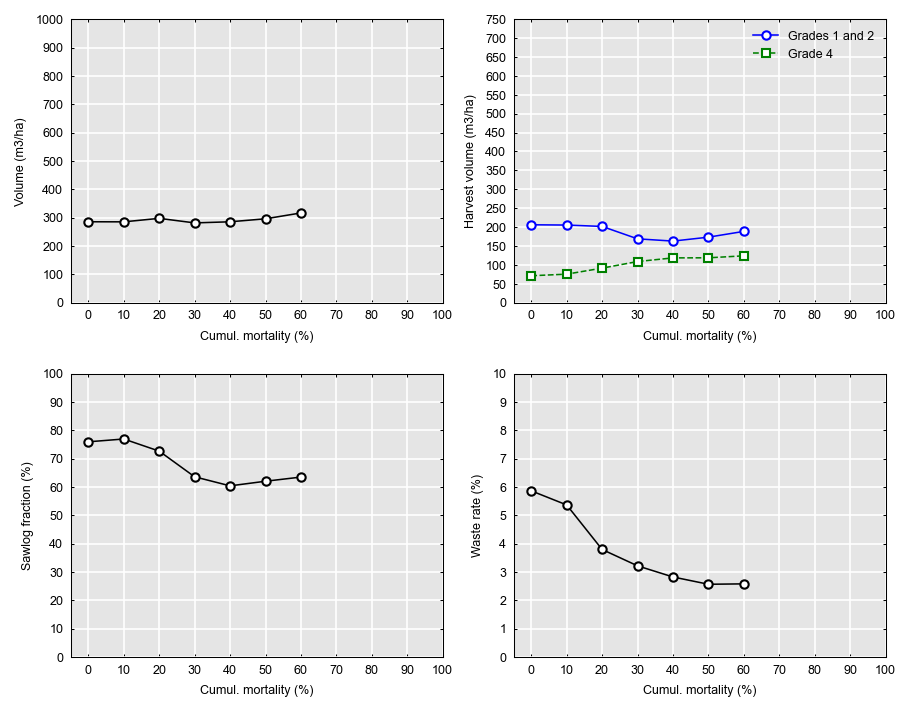

In [14]:
bin=np.arange(0,70,10)
Dist='DRM'
Dist='DQU'
Dist='DCC'

Vtot=np.zeros(bin.size)
V12=np.zeros(bin.size)
V4=np.zeros(bin.size)
SR=np.zeros(bin.size)
WR=np.zeros(bin.size)
for i in range(bin.size):
    ind=np.where( (np.abs(dTM['D_Beetle']-bin[i])<=5) & \
                 (dTM['Reg']=='Interior') & \
                 (dTM['District']!='Empty') & \
                 (dTM['Year First']>2006) & \
                 (dTM['V Felled m3/ha']>0) & \
                 (dTM['V Felled m3/ha']<2000) & \
                 (dTM['Waste N Entries']>0) & \
                 (np.abs(dTM['Delta A %'])<100) & \
                 (dTM['Waste Net Area Tot']>0) & \
                 (dTM['Sawlog Ratio']>=0) & (dTM['Sawlog Ratio']<1) )[0]
    Vtot[i]=np.nanmean(dTM['V Logs Delivered Abs m3/ha'][ind])
    V12[i]=np.nanmean(dTM['V Logs Delivered Grade 1 Abs m3/ha'][ind]+dTM['V Logs Delivered Grade 2 Abs m3/ha'][ind])
    V4[i]=np.nanmean(dTM['V Logs Delivered Grade 4 Abs m3/ha'][ind])
    SR[i]=np.nanmean(dTM['Sawlog Ratio'][ind])*100
    WR[i]=np.nanmean(dTM['WR'][ind])*100
    
plt.close('all'); fig,ax=plt.subplots(2,2,figsize=gu.cm2inch(15,12)); ms=3; lw=0.5
ax[0,0].plot(bin,Vtot,'ok-',ms=4,lw=0.75,mfc='w')
#ax[0,0].plot(bin,V12+V4,'.k--',ms=4,lw=0.75,mfc='w')
ax[0,0].set(position=[0.06,0.56,0.42,0.4],ylim=[0,500],yticks=np.arange(0,1100,100),ylabel='Volume (m3/ha)', \
          xlim=[-5,65],xticks=np.arange(0,110,10),xlabel='Cumul. mortality (%)')
ax[0,0].yaxis.set_ticks_position('both'); ax[0,0].xaxis.set_ticks_position('both'); ax[0,0].tick_params(length=tickl)
    
ax[0,1].plot(bin,V12,'ob-',ms=4,lw=0.75,mfc='w',label='Grades 1 and 2')
ax[0,1].plot(bin,V4,'sg--',ms=4,lw=0.75,mfc='w',label='Grade 4')
ax[0,1].set(position=[0.56,0.56,0.42,0.4],ylim=[0,300],yticks=np.arange(0,800,50),ylabel='Harvest volume (m3/ha)', \
          xlim=[-5,65],xticks=np.arange(0,110,10),xlabel='Cumul. mortality (%)')
ax[0,1].yaxis.set_ticks_position('both'); ax[0,1].xaxis.set_ticks_position('both'); ax[0,1].tick_params(length=tickl)
ax[0,1].legend(loc='upper right',facecolor=[1,1,1],frameon=False);

ax[1,0].plot(bin,SR,'ok-',ms=4,lw=0.75,mfc='w')
#ax[1,0].plot(bin,(V12/(V12+V4))*100,'sg-',ms=4,lw=0.75,mfc='w')
ax[1,0].set(position=[0.06,0.06,0.42,0.4],ylim=[0,100],yticks=np.arange(0,110,10),ylabel='Sawlog fraction (%)', \
          xlim=[-5,65],xticks=np.arange(0,110,10),xlabel='Cumul. mortality (%)')
ax[1,0].yaxis.set_ticks_position('both'); ax[1,0].xaxis.set_ticks_position('both'); ax[1,0].tick_params(length=tickl)
    
ax[1,1].plot(bin,WR,'ok-',ms=4,lw=0.75,mfc='w')
ax[1,1].set(position=[0.56,0.06,0.42,0.4],ylim=[0,10],yticks=np.arange(0,11,1),ylabel='Waste rate (%)', \
          xlim=[-5,65],xticks=np.arange(0,110,10),xlabel='Cumul. mortality (%)')
ax[1,1].yaxis.set_ticks_position('both'); ax[1,1].xaxis.set_ticks_position('both'); ax[1,1].tick_params(length=tickl)

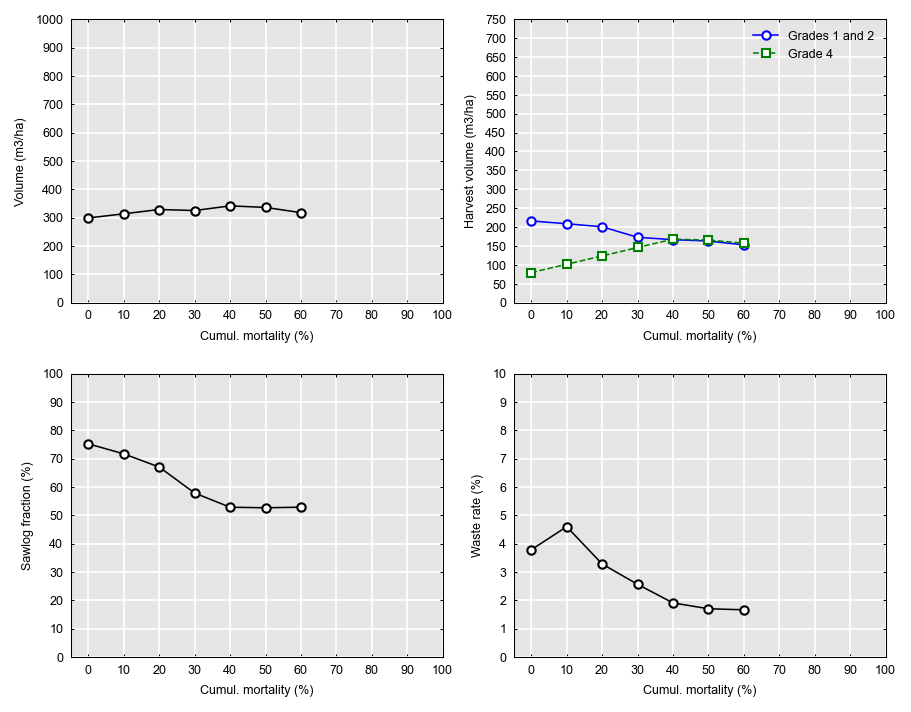

In [15]:
bin=np.arange(0,70,10)
#Dist='DRM' # Rocky Mountain
#Dist='DQU'
#Dist='DCC'
Dist='DPG'
#Dist='DMH'
#Dist='DKA'
#Dist='DCS'
#Dist='DMK'

Vtot=np.zeros(bin.size)
V12=np.zeros(bin.size)
V4=np.zeros(bin.size)
SR=np.zeros(bin.size)
WR=np.zeros(bin.size)
for i in range(bin.size):
    ind=np.where( (np.abs(dTM['D_Beetle']-bin[i])<=5) & \
                 (dTM['Reg']=='Interior') & \
                 (dTM['District']==Dist) & \
                 (dTM['Year First']>2006) & \
                 (dTM['V Felled m3/ha']>0) & \
                 (dTM['V Felled m3/ha']<2000) & \
                 (dTM['Waste N Entries']>0) & \
                 (np.abs(dTM['Delta A %'])<100) & \
                 (dTM['Waste Net Area Tot']>0) & \
                 (dTM['Sawlog Ratio']>=0) & (dTM['Sawlog Ratio']<1) )[0]
    Vtot[i]=np.nanmean(dTM['V Logs Delivered Abs m3/ha'][ind])
    V12[i]=np.nanmean(dTM['V Logs Delivered Grade 1 Abs m3/ha'][ind]+dTM['V Logs Delivered Grade 2 Abs m3/ha'][ind])
    V4[i]=np.nanmean(dTM['V Logs Delivered Grade 4 Abs m3/ha'][ind])
    SR[i]=np.nanmean(dTM['Sawlog Ratio'][ind])*100
    WR[i]=np.nanmean(dTM['WR'][ind])*100
    
plt.close('all'); fig,ax=plt.subplots(2,2,figsize=gu.cm2inch(15,12)); ms=3; lw=0.5
ax[0,0].plot(bin,Vtot,'ok-',ms=4,lw=0.75,mfc='w')
#ax[0,0].plot(bin,V12+V4,'.k--',ms=4,lw=0.75,mfc='w')
ax[0,0].set(position=[0.06,0.56,0.42,0.4],ylim=[0,500],yticks=np.arange(0,1100,100),ylabel='Volume (m3/ha)', \
          xlim=[-5,65],xticks=np.arange(0,110,10),xlabel='Cumul. mortality (%)')
ax[0,0].yaxis.set_ticks_position('both'); ax[0,0].xaxis.set_ticks_position('both'); ax[0,0].tick_params(length=tickl)
    
ax[0,1].plot(bin,V12,'ob-',ms=4,lw=0.75,mfc='w',label='Grades 1 and 2')
ax[0,1].plot(bin,V4,'sg--',ms=4,lw=0.75,mfc='w',label='Grade 4')
ax[0,1].set(position=[0.56,0.56,0.42,0.4],ylim=[0,300],yticks=np.arange(0,800,50),ylabel='Harvest volume (m3/ha)', \
          xlim=[-5,65],xticks=np.arange(0,110,10),xlabel='Cumul. mortality (%)')
ax[0,1].yaxis.set_ticks_position('both'); ax[0,1].xaxis.set_ticks_position('both'); ax[0,1].tick_params(length=tickl)
ax[0,1].legend(loc='upper right',facecolor=[1,1,1],frameon=False);

ax[1,0].plot(bin,SR,'ok-',ms=4,lw=0.75,mfc='w')
#ax[1,0].plot(bin,(V12/(V12+V4))*100,'sg-',ms=4,lw=0.75,mfc='w')
ax[1,0].set(position=[0.06,0.06,0.42,0.4],ylim=[0,100],yticks=np.arange(0,110,10),ylabel='Sawlog fraction (%)', \
          xlim=[-5,65],xticks=np.arange(0,110,10),xlabel='Cumul. mortality (%)')
ax[1,0].yaxis.set_ticks_position('both'); ax[1,0].xaxis.set_ticks_position('both'); ax[1,0].tick_params(length=tickl)
    
ax[1,1].plot(bin,WR,'ok-',ms=4,lw=0.75,mfc='w')
ax[1,1].set(position=[0.56,0.06,0.42,0.4],ylim=[0,10],yticks=np.arange(0,11,1),ylabel='Waste rate (%)', \
          xlim=[-5,65],xticks=np.arange(0,110,10),xlabel='Cumul. mortality (%)')
ax[1,1].yaxis.set_ticks_position('both'); ax[1,1].xaxis.set_ticks_position('both'); ax[1,1].tick_params(length=tickl)

## Waste ratio stratified by year

In [16]:
dTM.keys()

dict_keys(['TM', 'N Openings', 'DISTURBANCE_GROSS_AREA', 'PLANNED_NET_BLOCK_AREA', 'Year First', 'Year Last', 'District', 'Tenure Type', 'V Logs Delivered m3', 'V Logs Delivered Abs m3', 'V Logs Delivered m3/ha', 'V Logs Delivered Abs m3/ha', 'V Logs Cruise m3/ha', 'V Logs Waste m3/ha', 'V Logs Delivered Grade 1 m3/ha', 'V Logs Delivered Grade 1 Abs m3/ha', 'V Logs Delivered Grade 1 Abs m3', 'V Logs Delivered Grade 2 m3/ha', 'V Logs Delivered Grade 2 Abs m3/ha', 'V Logs Delivered Grade 2 Abs m3', 'V Logs Delivered Grade 3 m3/ha', 'V Logs Delivered Grade 3 Abs m3/ha', 'V Logs Delivered Grade 3 Abs m3', 'V Logs Delivered Grade 4 m3/ha', 'V Logs Delivered Grade 4 Abs m3/ha', 'V Logs Delivered Grade 4 Abs m3', 'V Logs Delivered Grade 5 m3/ha', 'V Logs Delivered Grade 5 Abs m3/ha', 'V Logs Delivered Grade 5 Abs m3', 'V Logs Delivered Grade 6 m3/ha', 'V Logs Delivered Grade 6 Abs m3/ha', 'V Logs Delivered Grade 6 Abs m3', 'V Logs Delivered Grade 7 m3/ha', 'V Logs Delivered Grade 7 Abs m3/ha'

In [17]:
dTM

{'TM': array(['00028', '00043', '00273', ..., 'YW127', 'YW128', 'YW129'],
       dtype=object),
 'N Openings': array([2., 3., 5., ..., 1., 1., 1.]),
 'DISTURBANCE_GROSS_AREA': array([103., 125.,  59., ..., 125.,  70.,  30.]),
 'PLANNED_NET_BLOCK_AREA': array([103.,  nan,  nan, ..., 127.,  86.,  49.]),
 'Year First': array([1969., 1968., 1968., ..., 1991., 1991., 1991.]),
 'Year Last': array([1972., 1972., 1983., ..., 1993., 1996., 1995.]),
 'District': array(['', '', '', ..., '', '', ''], dtype=object),
 'Tenure Type': array(['', '', '', ..., '', '', ''], dtype=object),
 'V Logs Delivered m3': array([0., 0., 0., ..., 0., 0., 0.]),
 'V Logs Delivered Abs m3': array([0., 0., 0., ..., 0., 0., 0.]),
 'V Logs Delivered m3/ha': array([0., 0., 0., ..., 0., 0., 0.]),
 'V Logs Delivered Abs m3/ha': array([0., 0., 0., ..., 0., 0., 0.]),
 'V Logs Cruise m3/ha': array([0., 0., 0., ..., 0., 0., 0.]),
 'V Logs Waste m3/ha': array([0., 0., 0., ..., 0., 0., 0.]),
 'V Logs Delivered Grade 1 m3/ha': arr

In [18]:
tv=np.arange(2007,2021,1)
dT={}
dT['Year']=tv
dT['Waste Sawlog m3']=np.zeros(tv.size)
dT['Waste GradeY/4 m3']=np.zeros(tv.size)
dT['Waste Total m3']=np.zeros(tv.size)
dT['V Logs Delivered Grades 1 and 2 Abs m3']=np.zeros(tv.size)
dT['V Logs Delivered Grade 4 Abs m3']=np.zeros(tv.size)
for iT in range(tv.size):
    ind=np.where( (dTM['Year Last']==tv[iT]) )[0]
    #Area=np.sum(dTM['Waste Net Area Tot'][ind])
    dT['Waste Sawlog m3'][iT]=np.nansum(dTM['Waste Net Area Tot'][ind]*dTM['Waste Sawlog m3/ha'][ind])/1e6
    dT['Waste GradeY/4 m3'][iT]=np.nansum(dTM['Waste Net Area Tot'][ind]*dTM['Waste GradeY/4 m3/ha'][ind])/1e6
    dT['Waste Total m3'][iT]=np.nansum(dTM['Waste Net Area Tot'][ind]*dTM['Waste Total m3/ha'][ind])/1e6
    dT['V Logs Delivered Grades 1 and 2 Abs m3'][iT]=np.nansum(dTM['V Logs Delivered Grade 1 Abs m3'][ind]+dTM['V Logs Delivered Grade 2 Abs m3'][ind])/1e6
    dT['V Logs Delivered Grade 4 Abs m3'][iT]=np.nansum(dTM['V Logs Delivered Grade 4 Abs m3'][ind])/1e6
df=pd.DataFrame(dT)
df.to_excel(r'C:\Users\rhember\Documents\Data\Waste Wood\Waste By Year.xlsx',index=False)

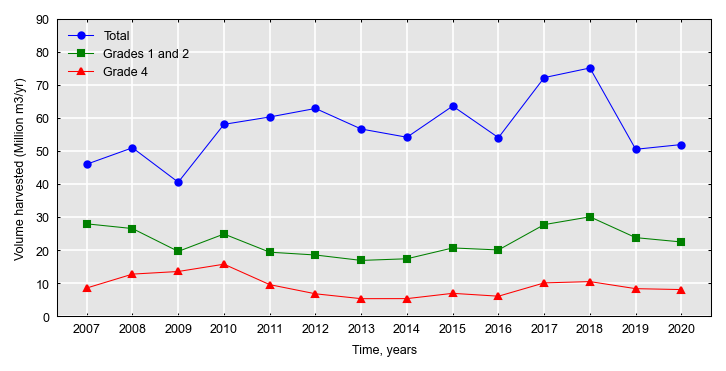

In [19]:
plt.close('all'); fig,ax=plt.subplots(1,figsize=gu.cm2inch(12,6)); ms=3; lw=0.5
Vtot=np.zeros(tv.size)
V12=np.zeros(tv.size)
V4=np.zeros(tv.size)
for iT in range(tv.size):
    ind=np.where( (dTM['Year Last']==tv[iT]) )[0]
    Vtot[iT]=np.nansum(dTM['V Logs Delivered Abs m3'][ind])/1e6
    V12[iT]=np.nansum(dTM['V Logs Delivered Grade 1 Abs m3'][ind]+dTM['V Logs Delivered Grade 2 Abs m3'][ind])/1e6
    V4[iT]=np.nansum(dTM['V Logs Delivered Grade 4 Abs m3'][ind])/1e6
ax.plot(tv,Vtot,'-bo',ms=ms,lw=lw,label='Total')
ax.plot(tv,V12,'-gs',ms=ms,lw=lw,label='Grades 1 and 2')
ax.plot(tv,V4,'-r^',ms=ms,lw=lw,label='Grade 4')
ax.set(ylim=[0,90],ylabel='Volume harvested (Million m3/yr)',xticks=np.arange(2007,2021,1),xlabel='Time, years')
ax.yaxis.set_ticks_position('both'); ax.xaxis.set_ticks_position('both'); ax.tick_params(length=1.5)
ax.legend(loc='upper left',facecolor=[1,1,1],frameon=False);

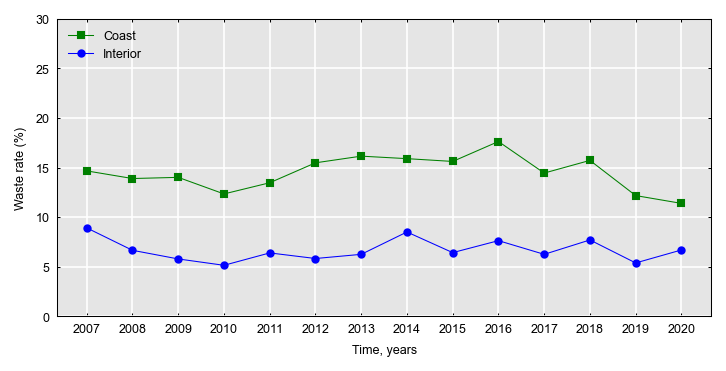

In [20]:
tv=np.arange(2007,2021,1)

plt.close('all'); fig,ax=plt.subplots(1,figsize=gu.cm2inch(12,6)); ms=3; lw=0.5

tv=np.arange(2007,2021,1)
plt.close('all'); fig,ax=plt.subplots(1,figsize=gu.cm2inch(12,6)); ms=3; lw=0.5
wr=np.zeros(tv.size)
for iT in range(tv.size):
    ind=np.where( (dTM['Year Last']==tv[iT]) & \
                 (dTM['Reg']=='Coast') & \
                 (dTM['Waste N Entries']>0) & \
                 (np.abs(dTM['Delta A %'])<100) & \
                 (dTM['Waste Net Area Tot']>0) & \
                 (dTM['WR']>=0) & (dTM['WR']<1) & \
                 (dTM['V Felled m3/ha']>0) & \
                 (dTM['V Felled m3/ha']<2000) )[0]
    wr[iT]=np.nanmean(dTM['WR'][ind])*100
    #w=dTM['Waste Total m3/ha'][ind]*dTM['DISTURBANCE_GROSS_AREA'][ind]
    #vf=dTM['V Felled m3/ha'][ind]*dTM['DISTURBANCE_GROSS_AREA'][ind]
    #wr[iT]=np.sum(w)/np.sum(vf)*100    
ax.plot(tv,wr,'-gs',ms=ms,lw=lw,label='Coast')

wr=np.zeros(tv.size)
for iT in range(tv.size):
    ind=np.where( (dTM['Year Last']==tv[iT]) & \
                 (dTM['Reg']=='Interior') & \
                 (dTM['Waste N Entries']>0) & \
                 (np.abs(dTM['Delta A %'])<100) & \
                 (dTM['Waste Net Area Tot']>0) & \
                 (dTM['WR']>=0) & (dTM['WR']<1) & \
                 (dTM['V Felled m3/ha']>0) & 
                 (dTM['V Felled m3/ha']<2000) )[0]
    wr[iT]=np.nanmean(dTM['WR'][ind])*100
    #w=dTM['Waste Total m3/ha'][ind]*dTM['DISTURBANCE_GROSS_AREA'][ind]
    #vf=dTM['V Felled m3/ha'][ind]*dTM['DISTURBANCE_GROSS_AREA'][ind]
    #wr[iT]=np.sum(w)/np.sum(vf)*100
ax.plot(tv,wr,'-bo',ms=ms,lw=lw,label='Interior')
ax.set(ylim=[0,30],ylabel='Waste rate (%)',xticks=np.arange(2007,2021,1),xlabel='Time, years')
ax.yaxis.set_ticks_position('both'); ax.xaxis.set_ticks_position('both'); ax.tick_params(length=1.5)
ax.legend(loc='upper left',facecolor=[1,1,1],frameon=False);

ax.set(ylim=[0,30],ylabel='Waste rate (%)',xticks=np.arange(2007,2021,1),xlabel='Time, years')
ax.yaxis.set_ticks_position('both'); ax.xaxis.set_ticks_position('both'); ax.tick_params(length=1.5)
ax.legend(loc='upper left',facecolor=[1,1,1],frameon=False);

In [21]:
#Dist='DRM' # Rocky Mountain
#Dist='DQU'
Dist='DCC'
#Dist='DPG'
#Dist='DMH'
#Dist='DKA'
#Dist='DCS'
#Dist='DMK'

In [22]:
dT={}
for k in dTM.keys():
    dT[k]=np.zeros(tv.size)
for iT in range(tv.size):
    ind=np.where( (dTM['Year Last']==tv[iT]) & \
                 (dTM['District']==Dist) & \
                 (dTM['Waste N Entries']>0) & \
                 (np.abs(dTM['Delta A %'])<100) & \
                 (dTM['Waste Net Area Tot']>0) & \
                 (dTM['WR']>=0) & (dTM['WR']<1) & \
                 (dTM['V Felled m3/ha']>0) & \
                 (dTM['V Felled m3/ha']<2000) )[0]
    for k in dTM.keys():
        try:
            dT[k][iT]=np.nanmean(dTM[k][ind]) 
        except:
            pass

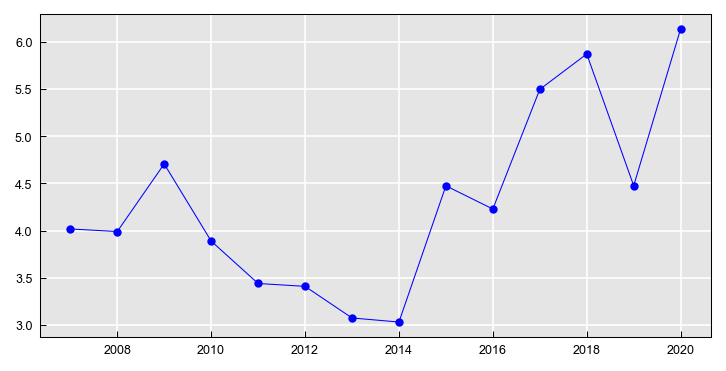

In [23]:
plt.close('all'); fig,ax=plt.subplots(1,figsize=gu.cm2inch(12,6)); ms=3; lw=0.5
ax.plot(tv,dT['WR']*100,'-bo',ms=ms,lw=lw,label='Coast')
#ax.set(ylim=[0,30],ylabel='Waste rate (%)',xticks=np.arange(2007,2021,1),xlabel='Time, years')
#ax.yaxis.set_ticks_position('both'); ax.xaxis.set_ticks_position('both'); ax.tick_params(length=1.5)
#ax.legend(loc='upper left',facecolor=[1,1,1],frameon=False);

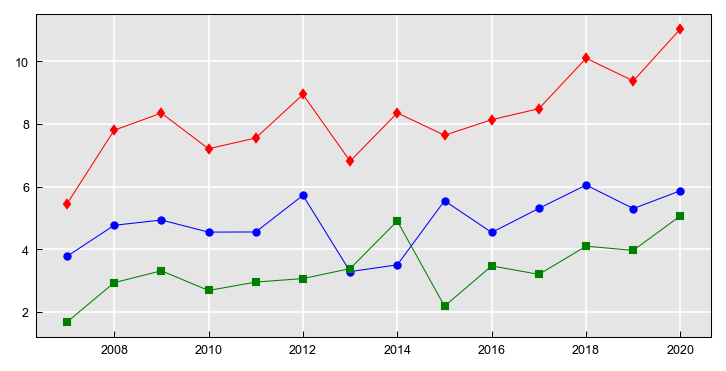

In [24]:
plt.close('all'); fig,ax=plt.subplots(1,figsize=gu.cm2inch(12,6)); ms=3; lw=0.5
ax.plot(tv,dT['Waste Sawlog m3/ha'],'-bo',ms=ms,lw=lw,label='Coast')
ax.plot(tv,dT['Waste GradeY/4 m3/ha'],'-gs',ms=ms,lw=lw,label='Coast')
ax.plot(tv,dT['Waste Total m3/ha'],'-rd',ms=ms,lw=lw,label='Coast');
#ax.set(ylim=[0,30],ylabel='Waste rate (%)',xticks=np.arange(2007,2021,1),xlabel='Time, years')
#ax.yaxis.set_ticks_position('both'); ax.xaxis.set_ticks_position('both'); ax.tick_params(length=1.5)
#ax.legend(loc='upper left',facecolor=[1,1,1],frameon=False);

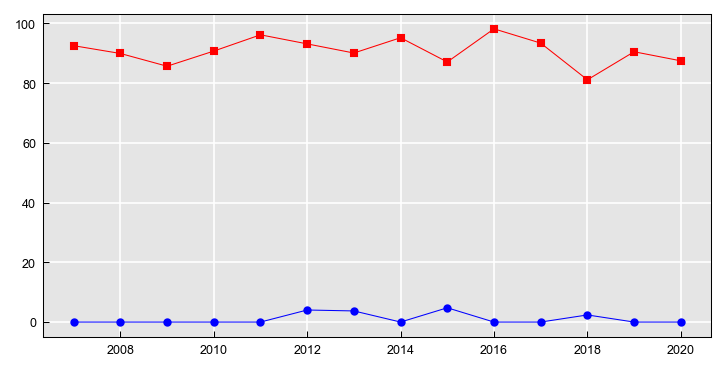

In [25]:
plt.close('all'); fig,ax=plt.subplots(1,figsize=gu.cm2inch(12,6)); ms=3; lw=0.5
ax.plot(tv,dT['Waste Standing %'],'-bo',ms=ms,lw=lw,label='Coast')
ax.plot(tv,dT['Waste Accumulation %'],'-rs',ms=ms,lw=lw,label='Coast')

In [26]:
dTM

{'TM': array(['00028', '00043', '00273', ..., 'YW127', 'YW128', 'YW129'],
       dtype=object),
 'N Openings': array([2., 3., 5., ..., 1., 1., 1.]),
 'DISTURBANCE_GROSS_AREA': array([103., 125.,  59., ..., 125.,  70.,  30.]),
 'PLANNED_NET_BLOCK_AREA': array([103.,  nan,  nan, ..., 127.,  86.,  49.]),
 'Year First': array([1969., 1968., 1968., ..., 1991., 1991., 1991.]),
 'Year Last': array([1972., 1972., 1983., ..., 1993., 1996., 1995.]),
 'District': array(['', '', '', ..., '', '', ''], dtype=object),
 'Tenure Type': array(['', '', '', ..., '', '', ''], dtype=object),
 'V Logs Delivered m3': array([0., 0., 0., ..., 0., 0., 0.]),
 'V Logs Delivered Abs m3': array([0., 0., 0., ..., 0., 0., 0.]),
 'V Logs Delivered m3/ha': array([0., 0., 0., ..., 0., 0., 0.]),
 'V Logs Delivered Abs m3/ha': array([0., 0., 0., ..., 0., 0., 0.]),
 'V Logs Cruise m3/ha': array([0., 0., 0., ..., 0., 0., 0.]),
 'V Logs Waste m3/ha': array([0., 0., 0., ..., 0., 0., 0.]),
 'V Logs Delivered Grade 1 m3/ha': arr